In [1]:
from env import RandomWalk
from policy import equiprobable_policy
from algo import td0, mc_prediction

import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
import os


plt.style.use('seaborn-v0_8-bright')

In [2]:
FIG_BASE_DIR = 'figures/'

if not os.path.exists(FIG_BASE_DIR):
    os.makedirs(FIG_BASE_DIR)

In [3]:
# Set up the environment + initial value function
env = RandomWalk()
initial_V = np.zeros(env.observation_space.n)
initial_V[1:-1] = 0.5

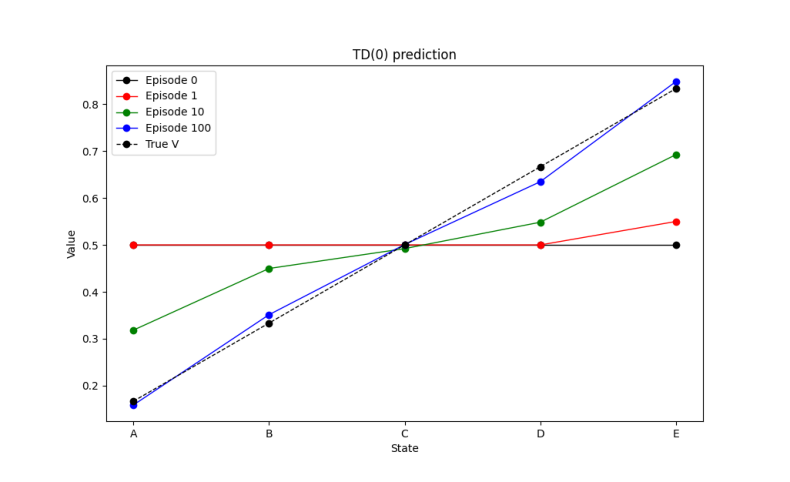

In [4]:
V_T0_ESTIMATES_FIG = os.path.join(FIG_BASE_DIR, 'V_T0_estimates.png')

if os.path.exists(V_T0_ESTIMATES_FIG):
    # load and plot png file
    plt.figure(figsize=(10, 6))
    plt.imshow(plt.imread(V_T0_ESTIMATES_FIG))
    plt.axis('off')
    plt.show()
else:
    V_T0, estimates_over_time_T0 = td0(env, equiprobable_policy(env), alpha=0.1, gamma=1, n_episodes=101, initial_V=initial_V, verbose=True)

    episodes_of_interest = [0, 1, 10, 100]
    true_V = np.arange(1, 6) / 6
    x = np.arange(1, 6)
    line_colors = ['black', 'red', 'green', 'blue']
    plt.figure(figsize=(10, 6))
    for i, ep_idx in enumerate(episodes_of_interest):
        plt.plot(x, estimates_over_time_T0[ep_idx][1:6], label=f'Episode {ep_idx}', color=line_colors[i], marker='o', linewidth=1)
    plt.plot(x,true_V, label='True V', color='black', linestyle='--', marker='o', linewidth=1)
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.xticks(np.arange(1, 6), ['A', 'B', 'C', 'D', 'E'])
    plt.legend()
    plt.title('TD(0) prediction')
    plt.savefig(V_T0_ESTIMATES_FIG)
    plt.show()

In [5]:
def rmse(V1, V2):
    """
    Simple function to calculate the root mean squared error between two value functions
    """
    return np.sqrt(np.mean((V1 - V2) ** 2))

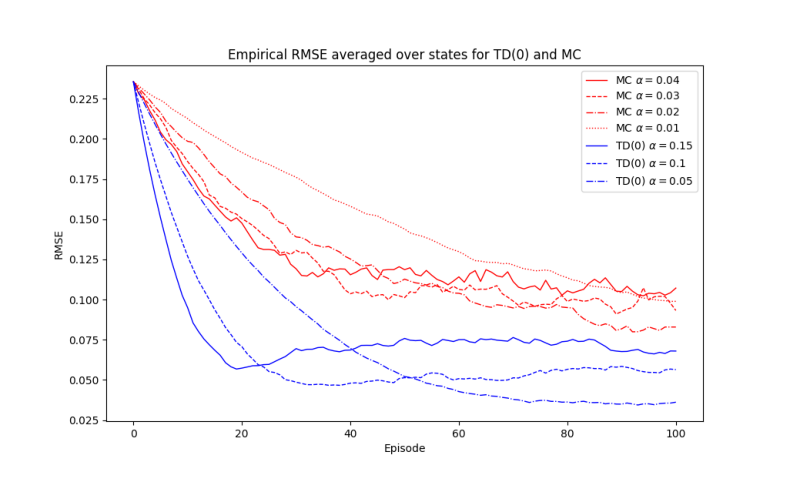

In [6]:
MC_VS_TD0_RMSE_FIG = os.path.join(FIG_BASE_DIR, 'MC_vs_TD0_RMSE.png')

linestyles = ['-', '--', '-.', ':']
alphas_MC = [0.04, 0.03, 0.02, 0.01]
alphas_T0 = [0.15, 0.1, 0.05]
NUM_EPISODES = 101
NUM_RUNS = 100

if os.path.exists(MC_VS_TD0_RMSE_FIG):
    # load and plot png file
    plt.figure(figsize=(10, 6))
    plt.imshow(plt.imread(MC_VS_TD0_RMSE_FIG))
    plt.axis('off')
    plt.show()
else:
    plt.figure(figsize=(10, 6))
    for i, alpha in enumerate(alphas_MC):
        V_over_time = np.zeros((NUM_RUNS, NUM_EPISODES, env.observation_space.n))
        for r in trange(NUM_RUNS):
            V, V_over_time[r] = mc_prediction(env, equiprobable_policy(env), alpha=alpha, gamma=1, n_episodes=NUM_EPISODES, initial_V=initial_V)
        rmse_over_time = np.apply_along_axis(lambda x: rmse(x[1:6], true_V), 2, V_over_time)
        rmse_over_time = np.mean(rmse_over_time, axis=0)
        plt.plot(rmse_over_time, label=f'MC $\\alpha={alpha}$', linewidth=1, color='red', linestyle=linestyles[i])

    for i, alpha in enumerate(alphas_T0):
        V_over_time = np.zeros((NUM_RUNS, NUM_EPISODES, env.observation_space.n))
        for r in trange(NUM_RUNS):
            V, V_over_time[r] = td0(env, equiprobable_policy(env), alpha=alpha, gamma=1, n_episodes=NUM_EPISODES, initial_V=initial_V)
        rmse_over_time = np.apply_along_axis(lambda x: rmse(x[1:6], true_V), 2, V_over_time)
        rmse_over_time = np.mean(rmse_over_time, axis=0)
        plt.plot(rmse_over_time, label=f'TD(0) $\\alpha={alpha}$', linewidth=1, color='blue', linestyle=linestyles[i])

    plt.xlabel('Episode')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title('Empirical RMSE averaged over states for TD(0) and MC')
    plt.savefig(MC_VS_TD0_RMSE_FIG)
    plt.show()